`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`     

**Выполнил студент ПМИ3-1 Поталайнен Илья**

**Вариант: 15**

# Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной #

Исходные данные:

* $X \sim U(5, 105)$   
* Для задачи 1: $Y = f(X) + \epsilon$, где $f(X) = 16 - 0.1X$ ; $\epsilon \sim N(0, 1)$.  
* Для задачи 2: $sigma = 2, 3, 4$.

# Задача 1

### Загрузка пакетов

In [105]:
import numpy as np, random, matplotlib.pyplot as plt, rpy2.robjects as robjects
from pandas import DataFrame

### Выполнены следующие операции:
* Создание выборки данных $x$ для имитации независимой переменной и генерация случайного шума $res$, моделирующего случайные ошибки в данных.
* Случайный отбор части наблюдений из общего набора данных для использования их в обучающей выборке, в то время как оставшиеся наблюдения будут применены для тестирования модели.
* Определение истинной функции взаимосвязи $y$_$func(x)$.
* Генерация фактических значений $y$.
* Разделение данных на обучающую и тестовую выборки.

In [118]:
np.random.seed(15)

n_all, train_percent = 60, 0.85

x_min, x_max = 5, 105
x = np.random.uniform(x_min, x_max, n_all)

mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

in_train = np.random.choice(n_all, int(n_all * train_percent), replace=False)

def y_func(x):
    return 16 - 0.1 * x

x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

y = y_func(x) + res

x_train, y_train = x[in_train], y[in_train]
x_test, y_test = np.delete(x, in_train), np.delete(y, in_train)

### Построение графиков

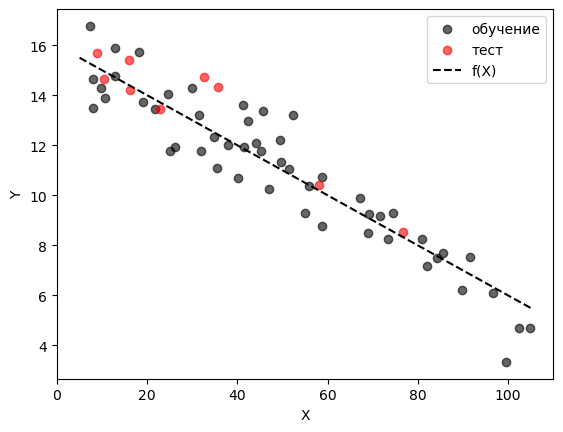

In [107]:
# график 1: исходные данные
# обучающая выборка
plt.scatter(x_train, y_train, c='black', label='обучение', alpha=0.6)
# тестовая выборка
plt.scatter(x_test, y_test, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.show()

## Обучение моделей и оценка их точности

Для моделирования используются сплайны с изменяющимися степенями свободы, которые варьируются от 2 (линейная модель) до 40 (модель с большим количеством степеней свободы, примерно равном 2/3 общего числа наблюдений). После построения моделей с разным количеством степеней свободы оценивается их точность на обучающей и тестовой выборках путем вычисления среднеквадратичной ошибки.

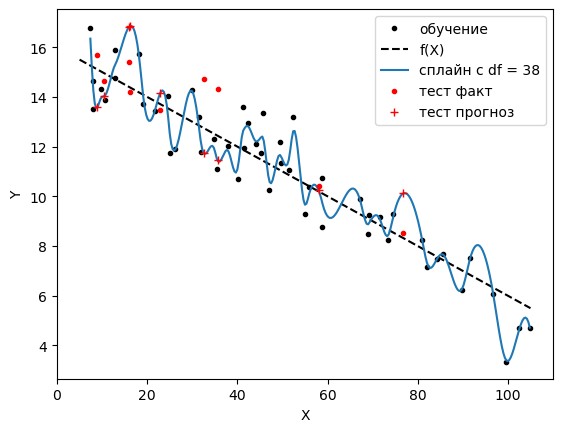

In [108]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38
# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
    sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [109]:
# выводим MSE с округлением
print(np.around(MSE_fit, 2))

[0.2 3.8]


In [110]:
# максимальное число степеней свободы для модели сплайна
max_df = 40
# фрейм данных для сохранения MSE на обучающей и на тестовой
# при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'], index=list(range(2, max_df+1)))
# заполняем фрейм
for i_df in range(2, max_df+1) :
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум $MSE$ на тестовой выборке достигается при числе степеней свободы:  

In [111]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
3,0.993422,0.994315


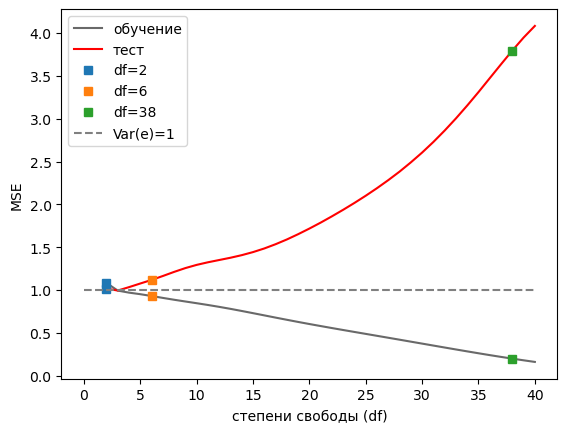

In [112]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
 marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
 marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
 MSE_all_dfs.iloc[0]['MSE_test']],
 ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
 MSE_all_dfs.iloc[4]['MSE_test']],
 ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
 MSE_all_dfs.iloc[36]['MSE_test']],
 ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()

# Вывод

Оптимальное количество степеней свободы для данной модели равно трём, так как при нем наблюдается минимальное значение среднеквадратической ошибки на тестовой выборке.

# Задача 2

### $sigma = 2$

In [152]:
np.random.seed(15)

n_all, train_percent = 60, 0.85

x_min, x_max = 5, 105
x = np.random.uniform(x_min, x_max, n_all)

mu, sigma = 0, 2
res = np.random.normal(mu, sigma, n_all)

in_train = np.random.choice(n_all, int(n_all * train_percent), replace=False)

def y_func(x):
    return 16 - 0.1 * x

x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

y = y_func(x) + res

x_train, y_train = x[in_train], y[in_train]
x_test, y_test = np.delete(x, in_train), np.delete(y, in_train)

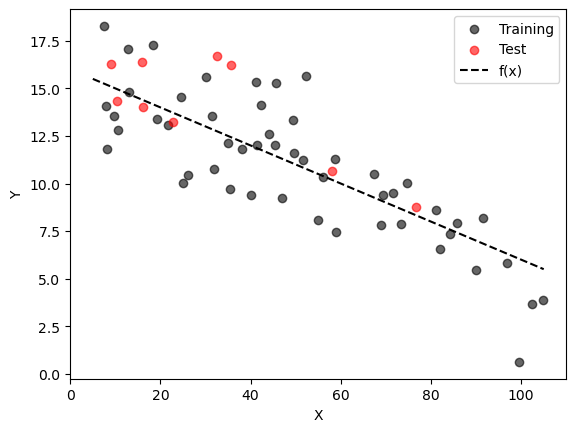

In [153]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

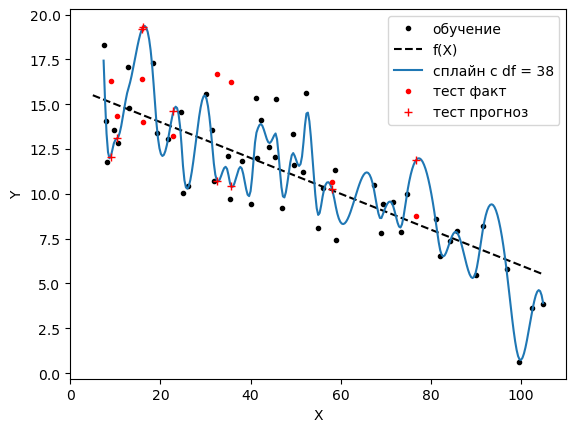

In [154]:
# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
    sum((y_test - y_hat_test)**2) / len(y_test)]

In [155]:
for i_df in range(2, max_df+1) :
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [156]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
3,3.973686,3.97726


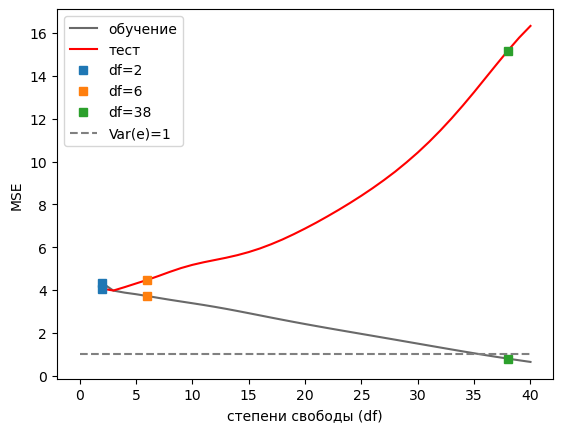

In [157]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
 marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
 marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
 MSE_all_dfs.iloc[0]['MSE_test']],
 ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
 MSE_all_dfs.iloc[4]['MSE_test']],
 ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
 MSE_all_dfs.iloc[36]['MSE_test']],
 ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()

### $sigma = 3$

In [158]:
np.random.seed(15)

n_all, train_percent = 60, 0.85

x_min, x_max = 5, 105
x = np.random.uniform(x_min, x_max, n_all)

mu, sigma = 0, 3
res = np.random.normal(mu, sigma, n_all)

in_train = np.random.choice(n_all, int(n_all * train_percent), replace=False)

def y_func(x):
    return 16 - 0.1 * x

x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

y = y_func(x) + res

x_train, y_train = x[in_train], y[in_train]
x_test, y_test = np.delete(x, in_train), np.delete(y, in_train)

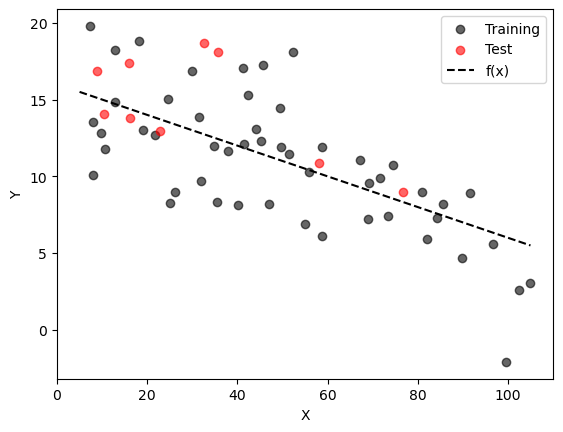

In [159]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

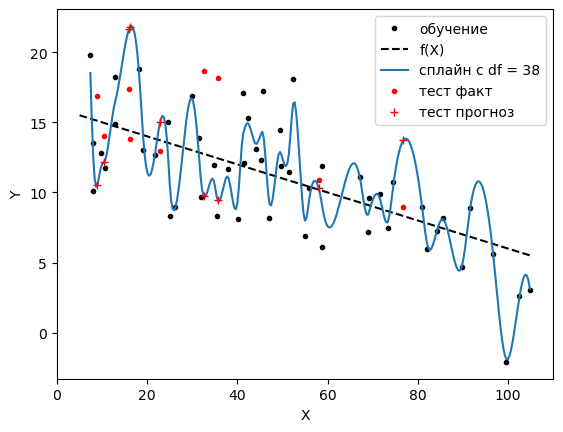

In [160]:
# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
    sum((y_test - y_hat_test)**2) / len(y_test)]

In [161]:
for i_df in range(2, max_df+1) :
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [162]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
3,8.940795,8.948835


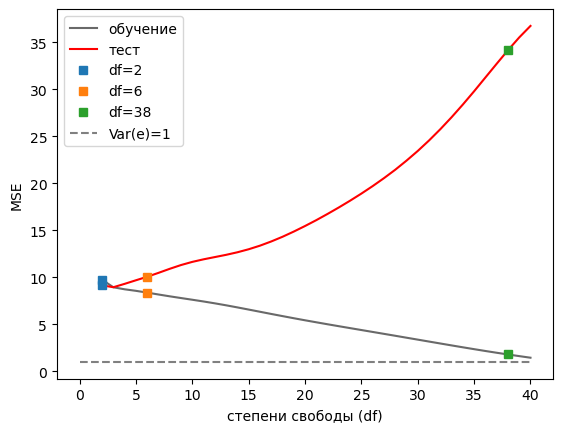

In [163]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
 marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
 marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
 MSE_all_dfs.iloc[0]['MSE_test']],
 ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
 MSE_all_dfs.iloc[4]['MSE_test']],
 ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
 MSE_all_dfs.iloc[36]['MSE_test']],
 ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()

### $sigma = 4$

In [169]:
np.random.seed(15)

n_all, train_percent = 60, 0.85

x_min, x_max = 5, 105
x = np.random.uniform(x_min, x_max, n_all)

mu, sigma = 0, 4
res = np.random.normal(mu, sigma, n_all)

in_train = np.random.choice(n_all, int(n_all * train_percent), replace=False)

def y_func(x):
    return 16 - 0.1 * x

x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

y = y_func(x) + res

x_train, y_train = x[in_train], y[in_train]
x_test, y_test = np.delete(x, in_train), np.delete(y, in_train)

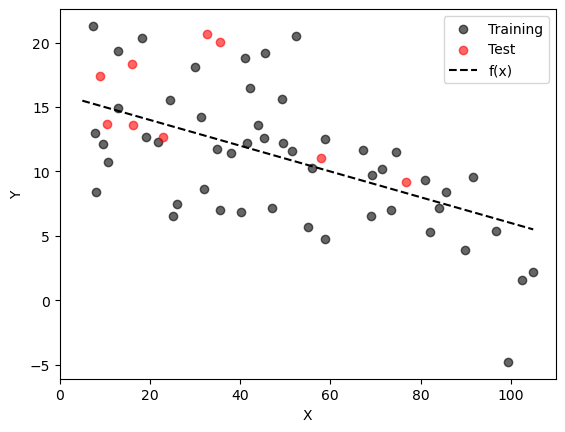

In [170]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

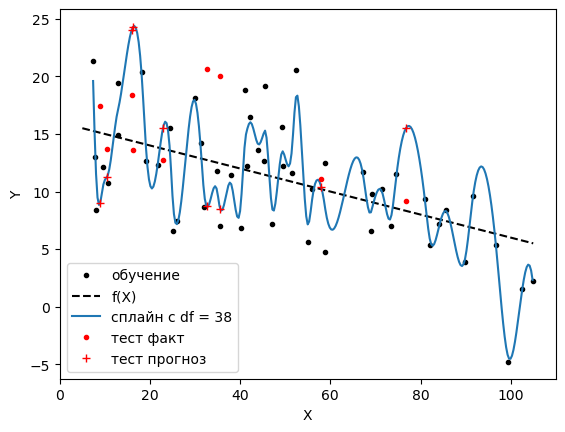

In [171]:
# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
    sum((y_test - y_hat_test)**2) / len(y_test)]

In [172]:
for i_df in range(2, max_df+1) :
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = \
    sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = \
    sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [173]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
3,15.894746,15.90904


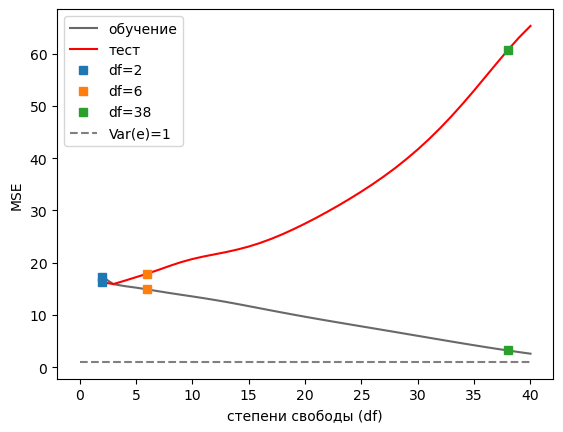

In [174]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
 marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
 marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
 MSE_all_dfs.iloc[0]['MSE_test']],
 ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
 MSE_all_dfs.iloc[4]['MSE_test']],
 ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
 MSE_all_dfs.iloc[36]['MSE_test']],
 ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()

## Вывод:

### При $sigma = 2$:
Наименьший показатель MSE достигается при числе степеней свободы равном 3:
* MSE Train = 3.973686	
* MSE Test = 3.97726

### При $sigma = 3$:
Наименьший показатель MSE достигается при числе степеней свободы равном 3:
* MSE Train = 8.940795
* MSE Test = 8.948835

### При $sigma = 4$:
Наименьший показатель MSE достигается при числе степеней свободы равном 3:
* MSE Train = 15.894746
* MSE Test = 15.90904

### Интерпретация результатов:

При увеличении значения параметра $sigma$ наблюдается увеличение среднеквадратических ошибок как на обучающей, так и на тестовой выборках. Это указывает на увеличение разброса прогнозов модели и ухудшение ее обобщающей способности.

При увеличении числа степеней свободы моделей происходит увеличение среднеквадратических ошибок на тестовой выборке, что свидетельствует о переобучении. Это означает, что модель слишком точно подстраивается под обучающие данные, теряя способность к обобщению на новых данных.